In [1]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [0]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy import special
from scipy.io import loadmat,savemat
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 


In [3]:
N = 256
M=1000
a = -1
b = 1.0
ti=0
to=2
batch_size=100

X = np.arange(a, b, (b-a)/N).reshape((N,1))
x_old=np.tile(X,(M,1))


Y = np.zeros(N)
y_old=np.tile(Y,(M,1)).reshape(M*N,1)

T=np.arange(ti,to,(to-ti)/M).reshape((M,1))
t_old=np.zeros([M*N,1])
count=0
for i in range (0,M):
  t_old[count:count+N]=T[i]  #### I've changed it to count+N
  count=count+N

idx=np.random.permutation(M*N)

x=x_old[idx,:]
y=y_old[idx,:]
t=t_old[idx,:]

print(np.shape(x))
print(np.shape(y))
print(np.shape(t))

(256000, 1)
(256000, 1)
(256000, 1)


In [4]:
n_nodes_hl1 = 50
n_nodes_hl2 = 50
n_nodes_hl3 = 50
n_nodes_hl4 = 50
n_nodes_hl5 = 50
n_nodes_hl6 = 50



n_classes = 1
learn_rate = 0.0003
x_ph = tf.placeholder('float', [None, 1],name='input')
t_ph = tf.placeholder('float', [None, 1],name='input_time')
y_ph = tf.placeholder('float',[None,1],name='forcing')
initializer = tf.contrib.layers.xavier_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:

hl_sigma = 0.02

# Routine to compute the neural network (5 hidden layers)
def neural_network_model(x_ph,t_ph):
    hidden_1_layer = {'weights': tf.Variable(initializer([2, n_nodes_hl1])),
                      'biases': tf.Variable(initializer([n_nodes_hl1]))}

    hidden_2_layer = {'weights': tf.Variable(initializer([n_nodes_hl1, n_nodes_hl2])),
                      'biases': tf.Variable(initializer([n_nodes_hl2]))}

    hidden_3_layer = {'weights': tf.Variable(initializer([n_nodes_hl2, n_nodes_hl3])),
                      'biases': tf.Variable(initializer([n_nodes_hl3]))}              

   
    
    hidden_4_layer = {'weights': tf.Variable(initializer([n_nodes_hl3, n_nodes_hl4])),
                      'biases': tf.Variable(initializer([n_nodes_hl4]))}              

    
    hidden_5_layer = {'weights': tf.Variable(initializer([n_nodes_hl4, n_nodes_hl5])),
                      'biases': tf.Variable(initializer([n_nodes_hl5]))}              




    output_layer = {'weights': tf.Variable(initializer([n_nodes_hl5, n_classes])),
                      'biases': tf.Variable(initializer([n_classes]))}


    # (input_data * weights) + biases
    L1 = tf.add(tf.matmul(tf.concat([x_ph,t_ph],axis=1), hidden_1_layer['weights']), hidden_1_layer['biases'])
    L1 = tf.nn.tanh(L1)   

    L2 = tf.add(tf.matmul(L1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    L2 = tf.nn.tanh(L2)

    L3 = tf.add(tf.matmul(L2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    L3 = tf.nn.tanh(L3)
    
    L4 = tf.add(tf.matmul(L3, hidden_4_layer['weights']), hidden_4_layer['biases'])
    L4 = tf.nn.tanh(L4)

    L5 = tf.add(tf.matmul(L4, hidden_5_layer['weights']), hidden_5_layer['biases'])
    L5 = tf.nn.tanh(L5)
    output = tf.add(tf.matmul(L5, output_layer['weights']), output_layer['biases'], name='output')

    return output, L1, L2, L3, L4, L5

In [0]:
def train_neural_network_batch(x_ph,t_ph, N, M, predict=False):
    prediction, L1, L2, L3, L4, L5 = neural_network_model(x_ph,t_ph)
    pred_dx = tf.gradients(prediction, x_ph)[0]
    pred_dx2 = tf.gradients(tf.gradients(prediction, x_ph),x_ph)[0]
    pred_dt=tf.gradients(prediction,t_ph)[0]
    
    u=tf.math.sin(-(math.pi)*x_ph)+(1+x_ph)*(1-x_ph)*t_ph*prediction
    
    usq=tf.math.square(u)
    usq_dx=tf.gradients(usq,x_ph)[0]
    u_x=tf.gradients(u,x_ph)[0]
    u_xx=tf.gradients(u_x,x_ph)[0]
    u_t=tf.gradients(u,t_ph)[0]
    # Compute u and its second derivative
    #u = A + B*x_ph + (x_ph*x_ph)*prediction
    #dudx2 = (x_ph*x_ph)*pred_dx2 + 2.0*x_ph*pred_dx + 2.0*x_ph*pred_dx + 2.0*prediction
     
    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    #cost = tf.reduce_mean(tf.square(pred_dt- pred*pred_dx - pred_dx2 - y_ph))
    cost=tf.reduce_mean(tf.square(u_t + u*u_x - (0.01)*u_xx - y_ph))
    #cost=tf.reduce_mean(tf.square(u_t - (0.01/math.pi)*u_xx - y_ph))

    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs = 2000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):
            #print('Epoch',epoch)
            epoch_loss = 0
            #for step in range(M*N//batch_size):
            #  idx=step*batch_size
            #  inputX=x[idx:idx+batch_size,0].reshape([batch_size,1])
            #  inputY=y[idx:idx+batch_size,0].reshape([batch_size,1])
            #  inputT=t[idx:idx+batch_size,0].reshape([batch_size,1])
              #print(np.shape(inputX),np.shape(inputT),np.shape(inputY))   
            _, l = sess.run([optimizer,cost], feed_dict={x_ph:x, t_ph:t, y_ph:y})
            epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', float(epoch_loss))


        # Predict a new input by adding a random number, to check whether the network has actually learned
        #x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
 
           
        mypred =(sess.run(tf.squeeze(u),{x_ph:x_old,t_ph:t_old}))
        mypred_dx=(sess.run(tf.squeeze(u_x),{x_ph:x_old,t_ph:t_old}))
        #L1_np=(L1.eval())
        #L2_np=(L2.eval())
        #L3_np=(L3.eval())
        #L4_np=(L4.eval())
        return mypred, mypred_dx, 

In [8]:
pred, pred_dx = train_neural_network_batch(x_ph,t_ph,N,M)

Epoch 0 completed out of 2000 loss: 1.3799265623092651
Epoch 10 completed out of 2000 loss: 0.6867729425430298
Epoch 20 completed out of 2000 loss: 0.3715617060661316
Epoch 30 completed out of 2000 loss: 0.2870479226112366
Epoch 40 completed out of 2000 loss: 0.2804179787635803
Epoch 50 completed out of 2000 loss: 0.2671048641204834
Epoch 60 completed out of 2000 loss: 0.2531026303768158
Epoch 70 completed out of 2000 loss: 0.24564588069915771
Epoch 80 completed out of 2000 loss: 0.23919707536697388
Epoch 90 completed out of 2000 loss: 0.2338455766439438
Epoch 100 completed out of 2000 loss: 0.23001079261302948
Epoch 110 completed out of 2000 loss: 0.2271714210510254
Epoch 120 completed out of 2000 loss: 0.2251531034708023
Epoch 130 completed out of 2000 loss: 0.22365695238113403
Epoch 140 completed out of 2000 loss: 0.22249844670295715
Epoch 150 completed out of 2000 loss: 0.22153852880001068
Epoch 160 completed out of 2000 loss: 0.22069893777370453
Epoch 170 completed out of 2000 los

Text(0, 0.5, '$u$')

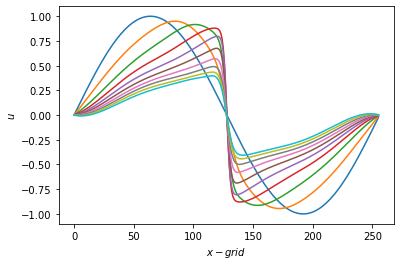

In [9]:
pred_reshape=np.reshape(pred,[N,M],order='F')

for i in range(0,1000):
    if (i % 100==0):
      plt.plot(pred_reshape[:,i],label='timestep'+''+str(i))

plt.xlabel('$x-grid$')
plt.ylabel('$u$')
#plt.legend()


In [0]:
np.savetxt('prediction_burger_v3.csv',pred_reshape,delimiter=',')